<a href="https://colab.research.google.com/github/MohammadUsman0/Deep-learning-models/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Shallow U-Net
A simple Shallow( few layers depth) U-Net model for image segmentation 


## 1. Import libraries and modules

In [46]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from keras.models import Model
from keras.datasets import mnist
from keras.callbacks import TensorBoard
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split

In [47]:
%cd /content/drive/MyDrive/Train_Data #set directory

[Errno 2] No such file or directory: '/content/drive/MyDrive/Train_Data #set directory'
/content/drive/MyDrive/Train_Data


## 2. Load dataset into train and test sets


In [48]:
# change the path according to your dataset directory strucutre
PATH = os.getcwd()
data_path = PATH + '/input'
mask_path=PATH + '/mask'

img_data_list=[]
mask_list=[]

data_dir_list = os.listdir(data_path)

for img in data_dir_list:
    input_img=cv2.imread(data_path + '/'+ img )
    input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    input_img_resize=cv2.resize(input_img,(128,128))
    img_data_list.append(input_img_resize)


img_data = np.array(img_data_list)


mask_dir_list = os.listdir(mask_path)

input_mask=[]
for msk in mask_dir_list:
    input_mask=cv2.imread(mask_path + '/'+ msk )
    input_mask=cv2.cvtColor(input_mask, cv2.COLOR_BGR2GRAY)
    input_mask_resize=cv2.resize(input_mask,(128,128))
    mask_list.append(input_mask_resize)

img_mask = np.array(mask_list)

In [49]:
x_train, x_test, y_train, y_test = train_test_split(img_data,img_mask, test_size=0.2, random_state=2) #train test split

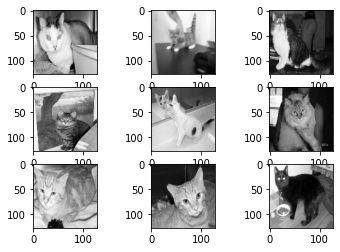

In [50]:
#plot some images from training data
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

## 3. Preprocess input data

In [51]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train = y_train.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 128, 128, 1))    # adapt this if using 'channels_first' image data format
x_test = np.reshape(x_test, (len(x_test), 128, 128, 1))       # adapt this if using 'channels_first' image data format
y_train = np.reshape(y_train, (len(y_train), 128, 128, 1))    # adapt this if using 'channels_first' image data format
y_test = np.reshape(y_test, (len(y_test), 128, 128, 1))       # adapt this if using 'channels_first' image data format

print(x_train.shape[0], "x_train samples")
print(x_test.shape[0], "x_test samples")
print(y_train.shape[0], "y_train samples")
print(y_test.shape[0], "y_test samples")

64 x_train samples
17 x_test samples
64 y_train samples
17 y_test samples


## 5. Define U-Net model architecture

In [52]:
#Down Sampling
input_img = Input(shape=(128, 128, 1))    # 128 , 128,1

conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(input_img) #(128,128,16)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)                      #(32,32,16)

conv2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool1)    #   (32,32,32)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)                     #   (16,16,32)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool2)     #   (16,16,128)
pool3 = MaxPooling2D((2, 2), padding='same')(conv3)                      #  (8,8,128)   

conv4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool3)   #   (8,8,128)
drop4=Dropout(0.5)(conv4)                                               #   (8,8,128)


#Up sampling
up5 = Conv2D(128, (2, 2), activation='relu', padding='same', kernel_initializer = 'he_normal')(UpSampling2D((2, 2))(drop4))    #(16,16,128) (16,16,128)
merge5 = concatenate([conv3,up5], axis=3)                                                    #(16,16,128)
conv5=Conv2D(128,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge5)                           #(16,16,128)

up6 = Conv2D(32, (2, 2), activation='relu', padding='same', kernel_initializer = 'he_normal')(UpSampling2D((2, 2))(conv5))    #(32,32,128) (32,32,32)
merge6 = concatenate([conv2,up6], axis=3)
conv6=Conv2D(32,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge6)                           #(32,32,128)

up7 = Conv2D(16, (2, 2), activation='relu', padding='same', kernel_initializer = 'he_normal')(UpSampling2D((2, 2))(conv6))    #(32,32,16)
merge7 = concatenate([conv1,up7], axis=3)
conv7=Conv2D(16,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge7)

conv8=Conv2D(16,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)
conv8=Conv2D(2,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv8)
decoder=Conv2D(1,(3,3), activation='sigmoid', padding='same')(conv8)

model = Model(input_img, decoder)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 128, 128, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_26[0][0]                  
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 64, 64, 32)   4640        max_pooling2d_6[0][0]            
____________________________________________________________________________________________

## 6. Compile model


In [53]:
model.compile(optimizer='adam', loss='binary_crossentropy')

## 7. Fit model


In [54]:
batch_size = 32
epochs = 5

history=model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/5
2/2 [==============================] - 10s 5s/step - loss: 0.6945 - val_loss: 0.6916
Epoch 2/5
2/2 [==============================] - 9s 5s/step - loss: 0.6868 - val_loss: 0.7150
Epoch 3/5
2/2 [==============================] - 9s 5s/step - loss: 0.6888 - val_loss: 0.6853
Epoch 4/5
2/2 [==============================] - 9s 5s/step - loss: 0.6824 - val_loss: 0.6771
Epoch 5/5
2/2 [==============================] - 9s 5s/step - loss: 0.6756 - val_loss: 0.6868


In [55]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


No handles with labels found to put in legend.


[0.6931954026222229, 0.6856494545936584, 0.6853184700012207, 0.6811407804489136, 0.6766835451126099]
[0.6915790438652039, 0.7150189876556396, 0.6853305101394653, 0.6771153807640076, 0.6867743134498596]


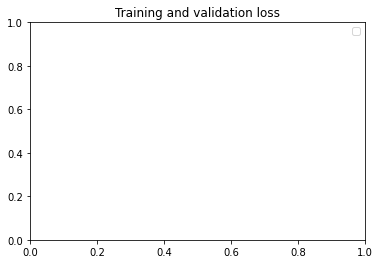

In [56]:
#plot model Accuracy and loss on training and validation data
loss = history.history['loss']
val_loss = history.history['val_loss']
print(loss)
print(val_loss)

#plt.plot(epochs, loss, 'b', color='green', label='Training loss')
#plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

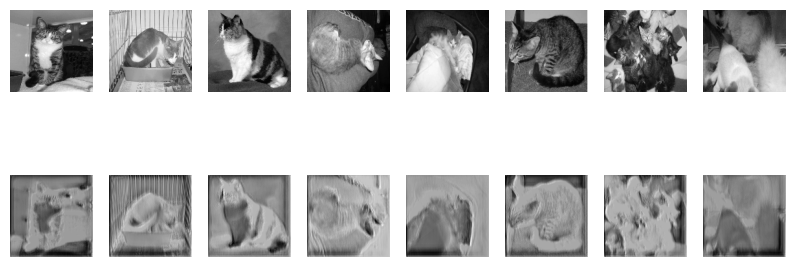

In [57]:
# take a look at the reconstructed images
decoded_imgs = model.predict(x_test)

n = 8
plt.figure(figsize=(10, 4), dpi=100)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128))
    plt.gray()
    ax.set_axis_off()

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(128,128 ))
    plt.gray()
    ax.set_axis_off()

plt.show()
